### Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해줌
%matplotlib inline
#seaborn을 활용한 그래프 스타일 지정
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

### Representing text as numerical data

In [2]:
#example text for model training
simple_train = ['call you tonight','Call me a cab',
'Please call me... PLEASE!']

먼저 CountVectorizer를 활용하여 토큰화를 진행해본다

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

vect.fit(simple_train)

#토큰 목록을 확인해보고 싶으면 get_feature_names_out()
vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [4]:
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [5]:
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

In [6]:
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


결국 단어를 vectorizer하게 되면 BOW(Bag Of Word)가 DataFrame으로 나오게 된다. 하지만 이 때 단어 순서 정보가 무시되는 단점이 있다.

In [9]:
print(type(simple_train_dtm))
print(simple_train_dtm)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


In [10]:
simple_test = ['please don`t call me']

In [12]:
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]], dtype=int64)

In [13]:
#여기서 don`t 는 단어장에 없었으므로 제외된 것을 볼 수 있다.
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


### 데이터 로드

In [14]:
sms = pd.read_csv('./data/spam.csv', encoding='latin-1')
#원래 노트북에서는 inplace사용했으나 바꿈
sms = sms.dropna(how='any', axis=1)
sms.columns = ['label', 'message']

sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### EDA

In [15]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [16]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

스팸: 747개, 비스팸: 4825개

In [17]:
sms['label_num'] = sms['label'].map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [18]:
sms['message_len'] = sms['message'].apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

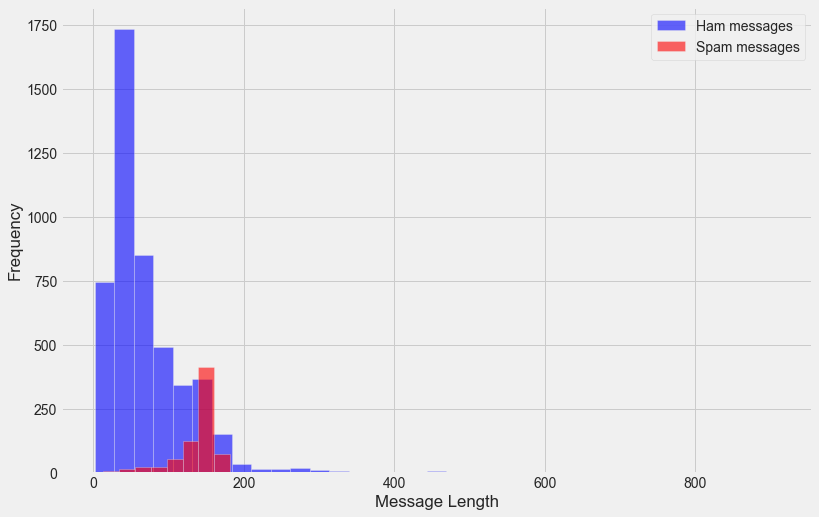

In [20]:
plt.figure(figsize=(12,8))

sms.loc[sms['label']=='ham','message_len'].plot(bins=35,
kind='hist',color='blue', label='Ham messages', alpha=0.6)
sms.loc[sms['label']=='spam','message_len'].plot(kind='hist',
color='red', label='Spam messages', alpha=0.6)

plt.legend()
plt.xlabel("Message Length")

스팸과 비스팸의 문자의 길이에서 차이가 난다는 점을 알 수 있다.

In [21]:
sms[sms['label']=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [22]:
sms[sms['label']=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


비스팸 메세지의 이상치를 탐색해보자

In [23]:
sms[sms['message_len'] == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

### 텍스트 전처리

In [33]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """

    1. 모든 구두점 제거
    2. 모든 불용어 제거
    3. 클린 텍스트 리스트로 반환

    """
    STOPWORDS = stopwords.words(
        'english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    #특수기호 제거
    nopunc = [char for char in mess if char not in string.punctuation]

    nopunc = ''.join(nopunc)

    #if에서 불용어를 제거해주는 return
    return ' '.join([word for word in nopunc.split()
    if word.lower() not in STOPWORDS])


In [25]:
#구두점,특수기호 리스트 개꿀....ㅎ
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
#nltk에서 불용어 사전 다운받아야함
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [36]:
stopwords.words()

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [29]:
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [37]:
sms['clean_msg'] = sms['message'].apply(text_process)

sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [38]:
type(stopwords.words('english'))

list

Counter는 배열같은 파라미터를 넘겼을 때 중복된 데이터가 몇번씩 나오는지 알 수 있다.
문자열을 넘기면 문자열에서 몇 번씩 나타나는지 알 수 있다.

In [41]:
c = Counter(a=4, b=2, c=0, d=-2)
d = Counter(a=1, b=2, c=3, d=4)
c.update(d)
c

Counter({'a': 5, 'b': 4, 'c': 3, 'd': 2})

In [40]:
from collections import Counter

words = sms[sms['label']=='ham'].clean_msg.apply(lambda x:
[word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)

print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94)]


비스팸 메세지에서는 get, ltgt, ok, go와 같은 단어들의 빈도수가 높다

In [42]:
words = sms.loc[sms['label']=='spam','clean_msg'].apply(lambda x:
[word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)

print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


스팸문자에서는 call, free, txt, mobile의 단어 빈도수가 높다

### Vectorization

In [44]:
from sklearn.model_selection import train_test_split

X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5572,)
(5572,)
(4179,)
(1393,)
(4179,)
(1393,)


In [45]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

X_train_dtm = vect.transform(X_train)

X_train_dtm = vect.fit_transform(X_train)

print(type(X_train_dtm), X_train_dtm.shape)

X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse.csr.csr_matrix'> (4179, 7996)
<class 'scipy.sparse.csr.csr_matrix'> (1393, 7996)


In [47]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 34796 stored elements in Compressed Sparse Row format>

### Building and evaluating a model

In [48]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [49]:
%time nb.fit(X_train_dtm, y_train)

Wall time: 1.45 ms


MultinomialNB()

In [50]:
from sklearn import metrics

y_pred_class = nb.predict(X_test_dtm)

print('=======Accuracy Score=========')
print(metrics.accuracy_score(y_test, y_pred_class))

print('=========Confision Matrix============')
metrics.confusion_matrix(y_test,y_pred_class)

=======Accuracy Score=========
0.9827709978463748
=========Confision Matrix============


array([[1205,    8],
       [  16,  164]], dtype=int64)

In [51]:
#False Positives 체크
X_test[y_pred_class > y_test]

2418    Madamregret disturbancemight receive reference...
4598                                laid airtel line rest
386                                   Customer place call
1289    HeyGreat dealFarm tour 9am 5pm 95pax 50 deposi...
5094    Hi ShanilRakhesh herethanksi exchanged uncut d...
494                                      free nowcan call
759     Call youcarlos isare phones vibrate acting mig...
3140                                  Customer place call
Name: clean_msg, dtype: object

In [52]:
#False Negatives 체크
X_test[y_pred_class < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3528    Xmas New Years Eve tickets sale club day 10am ...
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
2078                         85233 FREERingtoneReply REAL
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
3057    unsubscribed services Get tons sexy babes hunk...
1021    Guess Somebody know secretly fancies Wanna fin...
4067    TBSPERSOLVO chasing us since Sept forå£38 defi...
3358         Sorry missed call lets talk time 07090201529
2821    ROMCAPspam Everyone around responding well pre...
2247    Back work 2morro half term C 2nite sexy passio...
Name: clean_msg, dtype: object

In [53]:
X_test[4949]

'Hi probably much fun get message thought id txt cos bored james farting night'

In [55]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]
y_pred_prob


array([2.11903975e-02, 3.97831612e-04, 1.06470895e-03, ...,
       1.31939653e-02, 9.99821127e-05, 6.04083365e-06])

In [56]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9774342768159751

In [57]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()),
                ('tfid', TfidfTransformer()),
                ('model',MultinomialNB())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('======Accuracy Score======')
print(metrics.accuracy_score(y_test,y_pred))

print('======Confusion Matrix=======')
metrics.confusion_matrix(y_test, y_pred)

======Accuracy Score======
0.9669777458722182
======Confusion Matrix=======


array([[1213,    0],
       [  46,  134]], dtype=int64)

### Comparing models

In [60]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

%time logreg.fit(X_train_dtm, y_train)

Wall time: 82.4 ms


LogisticRegression(solver='liblinear')

In [61]:
y_pred_class = logreg.predict(X_test_dtm)

y_pred_prob = logreg.predict_proba(X_test_dtm)[:,1]
y_pred_prob

array([0.01694418, 0.0152182 , 0.08261755, ..., 0.02198942, 0.00531726,
       0.00679188])

In [62]:
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test, y_pred_class))

# calculate AUC
print("=======ROC AUC Score===========")
print(metrics.roc_auc_score(y_test, y_pred_prob))


=======Accuracy Score===========
0.9842067480258435
=======Confision Matrix===========
[[1213    0]
 [  22  158]]
=======ROC AUC Score===========
0.9835714940001832


### Tuning the Vectorizer

In [64]:
vect

CountVectorizer()

In [65]:
vect = CountVectorizer(stop_words='english')

In [66]:
vect = CountVectorizer(ngram_range=(1,2))

In [67]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

In [68]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)